# Step 1: Load, Preprocess

In [23]:
import pandas as pd


In [24]:
def standardize_timestamp(timestamp_str):
    if pd.isna(timestamp_str):
        return timestamp_str
    if '.' not in str(timestamp_str):
        return str(timestamp_str) + '.000000'
    return str(timestamp_str)

In [25]:
worker_logs = pd.read_csv('03_worker_logs.csv')
worker_logs['start_time'] = worker_logs['start_time'].apply(standardize_timestamp)
worker_logs['end_time'] = worker_logs['end_time'].apply(standardize_timestamp)
worker_logs['start_time'] = pd.to_datetime(worker_logs['start_time'], format='%Y-%m-%dT%H:%M:%S.%f')
worker_logs['end_time'] = pd.to_datetime(worker_logs['end_time'], format='%Y-%m-%dT%H:%M:%S.%f')
worker_logs['processing_time'] = (worker_logs['end_time'] - worker_logs['start_time']).dt.total_seconds() * 1000

print("Worker logs:")
display(worker_logs.head())
log_length =  len(worker_logs)
print(f"Total log entries: {log_length}")
unique_events = worker_logs['event_id'].nunique()
print(f"Unique events: {unique_events}")



Worker logs:


,event_id,worker_id,start_time,end_time,status,processing_time
0,evt_0000000,worker-2,2025-07-12 09:15:00.000,2025-07-12 09:15:00.005,success,5.0
1,evt_0000001,worker-1,2025-07-12 09:15:00.005,2025-07-12 09:15:00.012,success,7.0
2,evt_0000002,worker-3,2025-07-12 09:15:00.010,2025-07-12 09:15:00.022,success,12.0
3,evt_0000003,worker-1,2025-07-12 09:15:00.015,2025-07-12 09:15:00.026,success,11.0
4,evt_0000004,worker-3,2025-07-12 09:15:00.020,2025-07-12 09:15:00.023,success,3.0


Total log entries: 70250
Unique events: 70000


# Step 2: Anomaly detection

In [26]:
event_counts = worker_logs['event_id'].value_counts()
retried_events = event_counts[event_counts > 1]
print(f"Events with retries: {retried_events}")

Events with retries: event_id
evt_0039442    2
evt_0024805    2
evt_0062933    2
evt_0062911    2
evt_0001752    2
              ..
evt_0034911    2
evt_0052333    2
evt_0069895    2
evt_0044009    2
evt_0043630    2
Name: count, Length: 250, dtype: int64


In [27]:
events_retried_more_than_once = event_counts[event_counts > 2]
print(f"Events retried more than once: {events_retried_more_than_once}")

Events retried more than once: Series([], Name: count, dtype: int64)


In [28]:
overlaps = []
overlap_details = []

for event_id in retried_events.index:
    event_logs = worker_logs[worker_logs['event_id'] == event_id].sort_values('start_time')
    
    # Check if first attempt's end time overlaps with second attempt's start time
    if event_logs.iloc[0]['end_time'] >= event_logs.iloc[1]['start_time']:
        # Calculate overlap duration
        overlap_start = event_logs.iloc[1]['start_time']
        overlap_end = event_logs.iloc[0]['end_time']
        overlap_duration = (overlap_end - overlap_start).total_seconds() * 1000  # ms
        
        overlaps.append(event_id)
        overlap_details.append({
            'event_id': event_id,
            'worker1': event_logs.iloc[0]['worker_id'],
            'worker2': event_logs.iloc[1]['worker_id'],
            'overlap_start': overlap_start,
            'overlap_end': overlap_end,
            'overlap_duration_ms': overlap_duration,
            'worker1_status': event_logs.iloc[0]['status'],
            'worker2_status': event_logs.iloc[1]['status']
        })

# Create a DataFrame with overlap details
overlap_df = pd.DataFrame(overlap_details)
if not overlap_df.empty:
    print(f"Found {len(overlaps)} events with overlapping processing windows")
    print(f"Average overlap duration: {overlap_df['overlap_duration_ms'].mean():.2f} ms")
    display(overlap_df.head())
else:
    print("No overlapping events found")

Found 250 events with overlapping processing windows
Average overlap duration: 10.44 ms


,event_id,worker1,worker2,overlap_start,overlap_end,overlap_duration_ms,worker1_status,worker2_status
0,evt_0039442,worker-3,worker-2,2025-07-12 09:18:17.210,2025-07-12 09:18:17.216,6.0,success,success
1,evt_0024805,worker-1,worker-3,2025-07-12 09:17:04.025,2025-07-12 09:17:04.031,6.0,success,success
2,evt_0062933,worker-2,worker-3,2025-07-12 09:20:14.665,2025-07-12 09:20:14.675,10.0,success,success
3,evt_0062911,worker-3,worker-1,2025-07-12 09:20:14.555,2025-07-12 09:20:14.566,11.0,success,success
4,evt_0001752,worker-3,worker-1,2025-07-12 09:15:08.760,2025-07-12 09:15:08.774,14.0,success,success


In [29]:
failed_jobs = []
crashed_jobs = []
failure_details = []

for _, row in worker_logs.iterrows():
    event_id = row['event_id']
    
    if row['status'] != 'success':
        failed_jobs.append(event_id)
        failure_details.append({
            'event_id': event_id,
            'worker_id': row['worker_id'],
            'start_time': row['start_time'],
            'end_time': row['end_time'] if not pd.isna(row['end_time']) else None,
            'status': row['status'],
            'failure_type': 'timeout',
            'processing_time': row['processing_time'] if not pd.isna(row['end_time']) else None
        })
    

failure_df = pd.DataFrame(failure_details)

failed_jobs = list(set(failed_jobs))
crashed_jobs = list(set(crashed_jobs))

print(f"Found {len(failed_jobs)} events with non-success status")

if not failure_df.empty:
    print("\nFailure details:")
    display(failure_df.head())
    
    failed_and_retried = set(failed_jobs).intersection(set(retried_events.index))
    overlaps_and_fails = set(overlaps).intersection(set(failed_jobs))
    print(f"\nEvents that failed and were retried: {len(failed_and_retried)}")
    print(f"Evebts that had overlaps and failed: {len(overlaps_and_fails)}")
    
else:
    print("No failures or crashes found")

Found 100 events with non-success status

Failure details:


,event_id,worker_id,start_time,end_time,status,failure_type,processing_time
0,evt_0000247,worker-3,2025-07-12 09:15:01.235,None,timeout,timeout,None
1,evt_0001203,worker-1,2025-07-12 09:15:06.015,None,timeout,timeout,None
2,evt_0001743,worker-2,2025-07-12 09:15:08.715,None,timeout,timeout,None
3,evt_0001884,worker-1,2025-07-12 09:15:09.420,None,timeout,timeout,None
4,evt_0002043,worker-2,2025-07-12 09:15:10.215,None,timeout,timeout,None



Events that failed and were retried: 0
Evebts that had overlaps and failed: 0


In [30]:
#Finally print all obtained data
print(f"Race condition events: {len(overlaps)}")
print(f"Failed jobs: {len(failed_jobs)}")
print(f"Failed and retried events: {len(failed_and_retried)}")
print(f"Failed and race condition events: {len(overlaps_and_fails)}")
print(f"Total clean events: {len(worker_logs) - len(failed_jobs) - len(overlaps)} ")

Race condition events: 250
Failed jobs: 100
Failed and retried events: 0
Failed and race condition events: 0
Total clean events: 69900 


# Part 3: Data Visualization

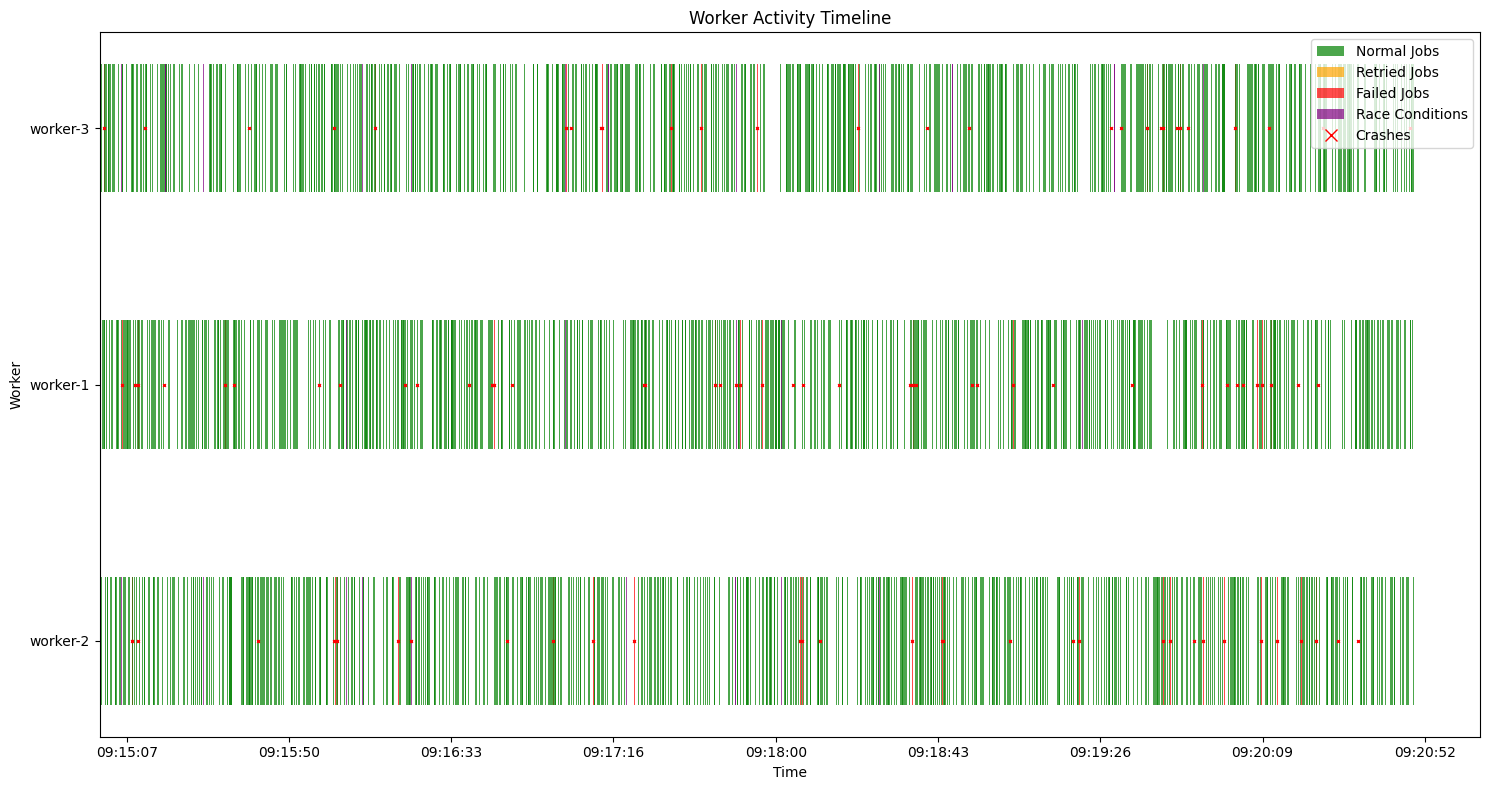


Timeline Analysis:
- 250 events had race conditions (overlapping processing)
- 100 events failed
- 250 events were retried (including overlaps)
- Race conditions are the primary cause of duplicate outputs


In [31]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch

# Timeline visualization
plt.figure(figsize=(15, 8))

# Get unique workers for y-axis positioning
workers = worker_logs['worker_id'].unique()
worker_positions = {worker: i for i, worker in enumerate(workers)}

# Plot each job
for _, row in worker_logs.iterrows():
    event_id = row['event_id']
    worker = row['worker_id']
    start = row['start_time']
    end = row['end_time'] if not pd.isna(row['end_time']) else start + pd.Timedelta(seconds=0.1)
    
    # Determine color based on job characteristics
    color = 'green'  # Default: normal job
    
    # Check if this specific job failed
    if row['status'] != 'success':
        color = 'red'
    # Check if this specific worker was involved in an overlap for this event
    elif not overlap_df.empty:
        overlap_match = overlap_df[
            (overlap_df['event_id'] == event_id) &
            ((overlap_df['worker1'] == worker) | (overlap_df['worker2'] == worker))
        ]
        if not overlap_match.empty:
            color = 'purple'
    # Check if this event was retried (but not overlapped)
    elif event_id in retried_events.index and event_id not in overlaps:
        color = 'orange'
    
    # Plot the job bar
    start_pos = mdates.date2num(start)
    end_pos = mdates.date2num(end)
    width = end_pos - start_pos
    plt.barh(worker_positions[worker], 
             width=width,
             left=mdates.date2num(start), 
             height=0.5,
             color=color,
             alpha=0.7)
    
    # Mark crashes with X
    if pd.isna(row['end_time']):
        plt.plot(mdates.date2num(start), worker_positions[worker], 'rx', markersize=2)

# Format plot
plt.yticks(list(worker_positions.values()), list(worker_positions.keys()))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.title('Worker Activity Timeline')
plt.xlabel('Time')
plt.ylabel('Worker')

# Legend
legend_elements = [
    Patch(facecolor='green', alpha=0.7, label='Normal Jobs'),
    Patch(facecolor='orange', alpha=0.7, label='Retried Jobs'),
    Patch(facecolor='red', alpha=0.7, label='Failed Jobs'),
    Patch(facecolor='purple', alpha=0.7, label='Race Conditions'),
    plt.Line2D([0], [0], marker='x', color='r', linestyle='None', markersize=8, label='Crashes')
]
plt.legend(handles=legend_elements, loc='upper right')
plt.tight_layout()
plt.show()

# Summary insights
print("\nTimeline Analysis:")
print(f"- {len(overlaps)} events had race conditions (overlapping processing)")
print(f"- {len(failed_jobs)} events failed")
print(f"- {len(retried_events)} events were retried (including overlaps)")
print(f"- Race conditions are the primary cause of duplicate outputs")

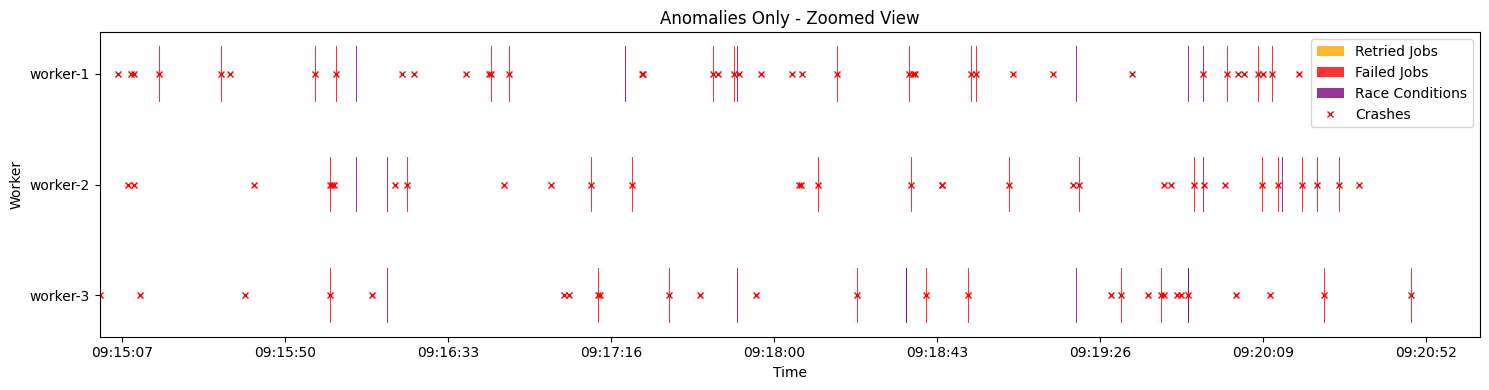


Anomalies View: Showing 600 anomalous jobs out of 70250 total jobs
Note that it is 600 because jobs with race conditions are counted twice , so total is 2* Race_Condition_jobs + Failed_Jobs


In [32]:
plt.figure(figsize=(15, 4))

overlapped_jobs = set()
if not overlap_df.empty:
    for _, row in overlap_df.iterrows():
        overlapped_jobs.add((row['event_id'], row['worker1']))
        overlapped_jobs.add((row['event_id'], row['worker2']))

# Filter for anomalies only - precise selection
anomaly_logs = worker_logs[
    (worker_logs['status'] != 'success') |  # Failed jobs
    (worker_logs.apply(lambda row: (row['event_id'], row['worker_id']) in overlapped_jobs, axis=1))  # Specific overlap participants
]

# Get unique workers for y-axis positioning
workers = anomaly_logs['worker_id'].unique()
worker_positions = {worker: i for i, worker in enumerate(workers)}

# Plot only anomalies with same logic but in separate chart
for _, row in anomaly_logs.iterrows():
    event_id = row['event_id']
    worker = row['worker_id']
    start = row['start_time']
    end = row['end_time'] if not pd.isna(row['end_time']) else start + pd.Timedelta(seconds=0.1)
    
    # Determine color based on job characteristics
    color = 'green'  # Default
    
    # Check if this specific job failed
    if row['status'] != 'success':
        color = 'red'
    # Check if this specific worker was involved in an overlap for this event
    elif not overlap_df.empty:
        overlap_match = overlap_df[
            (overlap_df['event_id'] == event_id) & 
            ((overlap_df['worker1'] == worker) | (overlap_df['worker2'] == worker))
        ]
        if not overlap_match.empty:
            color = 'purple'
    # Check if this event was retried (but not overlapped)
    elif event_id in retried_events.index:
        color = 'orange'
    
    # Plot the job bar
    start_pos = mdates.date2num(start)
    end_pos = mdates.date2num(end)
    width = end_pos - start_pos
    plt.barh(worker_positions[worker], 
             width=width,
             left=start_pos, 
             height=0.5,
             color=color,
             alpha=0.8)
    
    # Mark crashes with X
    if pd.isna(row['end_time']):
        plt.plot(start_pos, worker_positions[worker], 'rx', markersize=4)

# Format plot
plt.yticks(list(worker_positions.values()), list(worker_positions.keys()))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.title('Anomalies Only - Zoomed View')
plt.xlabel('Time')
plt.ylabel('Worker')

# Add same legend
legend_elements = [
    Patch(facecolor='orange', alpha=0.8, label='Retried Jobs'),
    Patch(facecolor='red', alpha=0.8, label='Failed Jobs'),
    Patch(facecolor='purple', alpha=0.8, label='Race Conditions'),
    plt.Line2D([0], [0], marker='x', color='r', linestyle='None', markersize=4, label='Crashes')
]
plt.legend(handles=legend_elements, loc='upper right')
plt.tight_layout()
plt.show()

print(f"\nAnomalies View: Showing {len(anomaly_logs)} anomalous jobs out of {len(worker_logs)} total jobs")
print(f"Note that it is {len(anomaly_logs)} because jobs with race conditions are counted twice , so total is 2* Race_Condition_jobs + Failed_Jobs")